In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import subprocess
import pickle
import torch
import os
from torchvision import transforms
from PIL import Image
import argparse
import os.path
import random
import torch
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

In [2]:
f = np.load('https://github.com/akatast/Continual_learn_RotMNIST/blob/main/mnist.npz')
x_tr = torch.from_numpy(f['x_train'])
y_tr = torch.from_numpy(f['y_train']).long()
x_te = torch.from_numpy(f['x_test'])
y_te = torch.from_numpy(f['y_test']).long()
f.close()
torch.save((x_tr, y_tr), 'mnist_train.pt')
torch.save((x_te, y_te), 'mnist_test.pt')
x_tr.size()[0]
print('Xtrain size: [%d , %d , %d ]' % (x_tr.size()[0], x_tr.size()[1],x_tr.size()[2]))
print('Xtest size: [%d , %d , %d ]' % (x_te.size()[0], x_te.size()[1],x_te.size()[2]))
print('Ytrain size: [%d ]' % (y_tr.size()[0]))
print('Ytest size: [%d ]' % (y_te.size()[0]))

Xtrain size: [60000 , 28 , 28 ]
Xtest size: [10000 , 28 , 28 ]
Ytrain size: [60000 ]
Ytest size: [10000 ]


Define function for rotating the dataset images:

In [3]:
def rotate_dataset(d, rotation):
    result = torch.FloatTensor(d.size(0), 784)
    tensor = transforms.ToTensor()

    for i in range(d.size(0)):
        img = Image.fromarray(d[i].numpy(), mode='L')
        result[i] = tensor(img.rotate(rotation)).view(784)
    return result

Creating traing and testing datasets (tasks, rotated set, labels):

In [4]:
#a_i = 'C:/Users/shriv/Rotated_Mnist_Output'
a_ntasks = 10
a_min_rot = 0
a_max_rot = 90
a_seed = 0

torch.manual_seed(a_seed)

tasks_tr = []
tasks_te = []

for t in range(a_ntasks):
    min_rot = 1.0 * t / a_ntasks * (a_max_rot - a_min_rot) + \
        a_min_rot
    max_rot = 1.0 * (t + 1) / a_ntasks * \
        (a_max_rot - a_min_rot) + a_min_rot
    rot = random.random() * (max_rot - min_rot) + min_rot

    tasks_tr.append([rot, rotate_dataset(x_tr, rot), y_tr])
    tasks_te.append([rot, rotate_dataset(x_te, rot), y_te])

Plotting a sample from the training dataset. The origial digit with its 10 rotations:

Rotation angles are:
8.943675007155099
12.581150674017694
26.658583107709486
34.71716005542774
43.03280513972153
49.32217587712052
60.559900373041536
70.85351841232436
76.23083802841474
87.97110669673172


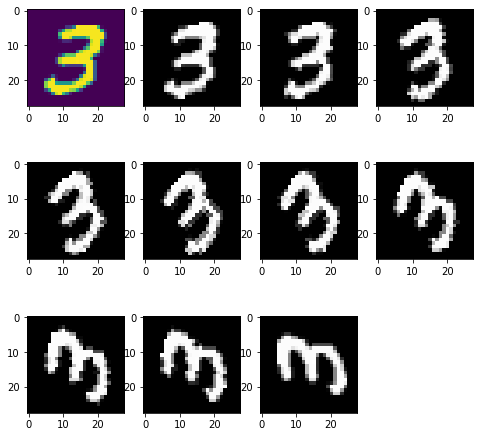

In [5]:
import numpy as np
import matplotlib.pyplot as plt

w=28
h=28
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 3
fig.add_subplot(rows, columns, 1)
plt.imshow(x_tr[7])
for i in range(10):
    x=tasks_tr[i][1][7]
    img = x.reshape((h, w))
    fig.add_subplot(rows, columns, i+2)
    plt.imshow(img, cmap=plt.cm.gray)

print('Rotation angles are:')
for i in range(10):
    print(tasks_tr[i][0])

Create the models that will be used for training:

In [6]:
import math
import torch
import torch.nn as nn
from torch.nn.functional import relu, avg_pool2d

In [7]:
def Xavier(m):
    if m.__class__.__name__ == 'Linear':
        fan_in, fan_out = m.weight.data.size(1), m.weight.data.size(0)
        std = 1.0 * math.sqrt(2.0 / (fan_in + fan_out))
        a = math.sqrt(3.0) * std
        m.weight.data.uniform_(-a, a)
        m.bias.data.fill_(0.0)

In [8]:
class MLP(nn.Module):
    def __init__(self, sizes):
        super(MLP, self).__init__()
        layers = []

        for i in range(0, len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < (len(sizes) - 2):
                layers.append(nn.ReLU())

        self.net = nn.Sequential(*layers)
        self.net.apply(Xavier)

    def forward(self, x):
        return self.net(x)

In [9]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [10]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = relu(out)
        return out


In [11]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, nf):
        super(ResNet, self).__init__()
        self.in_planes = nf

        self.conv1 = conv3x3(3, nf * 1)
        self.bn1 = nn.BatchNorm2d(nf * 1)
        self.layer1 = self._make_layer(block, nf * 1, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, nf * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, nf * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, nf * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(nf * 8 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        bsz = x.size(0)
        out = relu(self.bn1(self.conv1(x.view(bsz, 3, 32, 32))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(nclasses, nf=20):
    return ResNet(BasicBlock, [2, 2, 2, 2], nclasses, nf)

Define the metrics that will be used for evaluation:

In [12]:
from __future__ import print_function

import torch

In [13]:
def task_changes(result_t):
    n_tasks = int(result_t.max() + 1)
    changes = []
    current = result_t[0]
    for i, t in enumerate(result_t):
        if t != current:
            changes.append(i)
            current = t

    return n_tasks, changes


def confusion_matrix(result_t, result_a, fname=None):
    nt, changes = task_changes(result_t)

    baseline = result_a[0]
    changes = torch.LongTensor(changes + [result_a.size(0)]) - 1
    result = result_a[changes]

    # acc[t] equals result[t,t]
    acc = result.diag()
    fin = result[nt - 1]
    # bwt[t] equals result[T,t] - acc[t]
    bwt = result[nt - 1] - acc

    # fwt[t] equals result[t-1,t] - baseline[t]
    fwt = torch.zeros(nt)
    for t in range(1, nt):
        fwt[t] = result[t - 1, t] - baseline[t]

    if fname is not None:
        f = open(fname, 'w')

        print(' '.join(['%.4f' % r for r in baseline]), file=f)
        print('|', file=f)
        for row in range(result.size(0)):
            print(' '.join(['%.4f' % r for r in result[row]]), file=f)
        print('', file=f)
        # print('Diagonal Accuracy: %.4f' % acc.mean(), file=f)
        print('Final Accuracy: %.4f' % fin.mean(), file=f)
        print('Backward: %.4f' % bwt.mean(), file=f)
        print('Forward:  %.4f' % fwt.mean(), file=f)
        f.close()

    stats = []
    # stats.append(acc.mean())
    stats.append(fin.mean())
    stats.append(bwt.mean())
    stats.append(fwt.mean())

    return stats

Defining GEM Algorithm:
(GEM can be viewed as a model that learns the subset of correlations common to a set of distributions (tasks). GEM can also be used to predict target vectors associated to previous or new tasks without making use of task descriptors.

The challenges solved by GEM model are :

Non-iid input data: the continuum of data is not iid with respect to any fixed probability distribution P(X, T, Y ) since, once tasks switch, a whole sequence of examples from the new task may be observed.
Catastrophic forgetting: learning new tasks may hurt the performance of the learner at previously solved tasks.
Transfer learning: when the tasks in the continuum are related, there exists an opportunity for transfer learning. This would translate into faster learning of new tasks, as well as performance improvements in old tasks)

In [14]:
import torch.nn as nn
import torch.optim as optim
import quadprog

In [15]:
def compute_offsets(task, nc_per_task, is_cifar):
    """
        Compute offsets for cifar to determine which
        outputs to select for a given task.
    """
    if is_cifar:
        offset1 = task * nc_per_task
        offset2 = (task + 1) * nc_per_task
    else:
        offset1 = 0
        offset2 = nc_per_task
    return offset1, offset2

In [16]:
def store_grad(pp, grads, grad_dims, tid):
    """
        This stores parameter gradients of past tasks.
        pp: parameters
        grads: gradients
        grad_dims: list with number of parameters per layers
        tid: task id
    """
    # store the gradients
    grads[:, tid].fill_(0.0)
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            grads[beg: en, tid].copy_(param.grad.data.view(-1))
        cnt += 1

In [17]:
def overwrite_grad(pp, newgrad, grad_dims):
    """
        This is used to overwrite the gradients with a new gradient
        vector, whenever violations occur.
        pp: parameters
        newgrad: corrected gradient
        grad_dims: list storing number of parameters at each layer
    """
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            this_grad = newgrad[beg: en].contiguous().view(
                param.grad.data.size())
            param.grad.data.copy_(this_grad)
        cnt += 1

In [18]:
def project2cone2(gradient, memories, margin=0.5, eps=1e-3):
    """
        Solves the GEM dual QP described in the paper given a proposed
        gradient "gradient", and a memory of task gradients "memories".
        Overwrites "gradient" with the final projected update.
        input:  gradient, p-vector
        input:  memories, (t * p)-vector
        output: x, p-vector
    """
    memories_np = memories.cpu().t().double().numpy()
    gradient_np = gradient.cpu().contiguous().view(-1).double().numpy()
    t = memories_np.shape[0]
    P = np.dot(memories_np, memories_np.transpose())
    P = 0.5 * (P + P.transpose()) + np.eye(t) * eps
    q = np.dot(memories_np, gradient_np) * -1
    G = np.eye(t)
    h = np.zeros(t) + margin
    v = quadprog.solve_qp(P, q, G, h)[0]
    x = np.dot(v, memories_np) + gradient_np
    gradient.copy_(torch.Tensor(x).view(-1, 1))

In [19]:
class Net(nn.Module):
    def __init__(self,
                 n_inputs,
                 n_outputs,
                 n_tasks,
                 args):
        super(Net, self).__init__()
        nl, nh = args['n_layers'], args['n_hiddens']
        self.margin = args['memory_strength']
        self.is_cifar = (args['data_file'] == 'cifar100.pt')
        if self.is_cifar:
            self.net = ResNet18(n_outputs)
        else:
            self.net = MLP([n_inputs] + [nh] * nl + [n_outputs])

        self.ce = nn.CrossEntropyLoss()
        self.n_outputs = n_outputs

        self.opt = optim.SGD(self.parameters(), args['lr'])

        self.n_memories = args['n_memories']
        self.gpu = args['cuda']

        # allocate episodic memory
        self.memory_data = torch.FloatTensor(
            n_tasks, self.n_memories, n_inputs)
        self.memory_labs = torch.LongTensor(n_tasks, self.n_memories)
        if args['cuda']:
            self.memory_data = self.memory_data.cuda()
            self.memory_labs = self.memory_labs.cuda()

        # allocate temporary synaptic memory
        self.grad_dims = []
        for param in self.parameters():
            self.grad_dims.append(param.data.numel())
        self.grads = torch.Tensor(sum(self.grad_dims), n_tasks)
        if args['cuda']:
            self.grads = self.grads.cuda()

        # allocate counters
        self.observed_tasks = []
        self.old_task = -1
        self.mem_cnt = 0
        if self.is_cifar:
            self.nc_per_task = int(n_outputs / n_tasks)
        else:
            self.nc_per_task = n_outputs

    def forward(self, x, t):
        output = self.net(x)
        if self.is_cifar:
            # make sure we predict classes within the current task
            offset1 = int(t * self.nc_per_task)
            offset2 = int((t + 1) * self.nc_per_task)
            if offset1 > 0:
                output[:, :offset1].data.fill_(-10e10)
            if offset2 < self.n_outputs:
                output[:, offset2:self.n_outputs].data.fill_(-10e10)
        return output

    def observe(self, x, t, y):
        # update memory
        if t != self.old_task:
            self.observed_tasks.append(t)
            self.old_task = t

        # Update ring buffer storing examples from current task
        bsz = y.data.size(0)
        endcnt = min(self.mem_cnt + bsz, self.n_memories)
        effbsz = endcnt - self.mem_cnt
        self.memory_data[t, self.mem_cnt: endcnt].copy_(
            x.data[: effbsz])
        if bsz == 1:
            self.memory_labs[t, self.mem_cnt] = y.data[0]
        else:
            self.memory_labs[t, self.mem_cnt: endcnt].copy_(
                y.data[: effbsz])
        self.mem_cnt += effbsz
        if self.mem_cnt == self.n_memories:
            self.mem_cnt = 0

        # compute gradient on previous tasks
        if len(self.observed_tasks) > 1:
            for tt in range(len(self.observed_tasks) - 1):
                self.zero_grad()
                # fwd/bwd on the examples in the memory
                past_task = self.observed_tasks[tt]

                offset1, offset2 = compute_offsets(past_task, self.nc_per_task,
                                                   self.is_cifar)
                ptloss = self.ce(
                    self.forward(
                        self.memory_data[past_task],
                        past_task)[:, offset1: offset2],
                    self.memory_labs[past_task] - offset1)
                ptloss.backward()
                store_grad(self.parameters, self.grads, self.grad_dims,
                           past_task)

        # now compute the grad on the current minibatch
        self.zero_grad()

        offset1, offset2 = compute_offsets(t, self.nc_per_task, self.is_cifar)
        loss = self.ce(self.forward(x, t)[:, offset1: offset2], y - offset1)
        loss.backward()

        # check if gradient violates constraints
        if len(self.observed_tasks) > 1:
            # copy gradient
            store_grad(self.parameters, self.grads, self.grad_dims, t)
            indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \
                else torch.LongTensor(self.observed_tasks[:-1])
            dotp = torch.mm(self.grads[:, t].unsqueeze(0),
                            self.grads.index_select(1, indx))
            if (dotp < 0).sum() != 0:
                project2cone2(self.grads[:, t].unsqueeze(1),
                              self.grads.index_select(1, indx), self.margin)
                # copy gradients back
                overwrite_grad(self.parameters, self.grads[:, t],
                               self.grad_dims)
        self.opt.step()

Load Dataset:

In [20]:
import importlib
import datetime
import argparse
import random
import uuid
import time
import os

In [21]:
def load_datasets():
    d_tr, d_te = tasks_tr, tasks_te
    n_inputs = d_tr[0][1].size(1)
    n_outputs = 0
    for i in range(len(d_tr)):
        n_outputs = max(n_outputs, d_tr[i][2].max().item())
        n_outputs = max(n_outputs, d_te[i][2].max().item())
    return d_tr, d_te, n_inputs, n_outputs + 1, len(d_tr)

Define continuum of data:

In [22]:
class Continuum:

    def __init__(self, data, args):
        self.data = data
        self.batch_size = args['batch_size']
        n_tasks = len(data)
        task_permutation = range(n_tasks)

        if args['shuffle_tasks'] == 'yes':
            task_permutation = torch.randperm(n_tasks).tolist()

        sample_permutations = []

        for t in range(n_tasks):
            N = data[t][1].size(0)
            if args['samples_per_task'] <= 0:
                n = N
            else:
                n = min(args['samples_per_task'], N)

            p = torch.randperm(N)[0:n]
            sample_permutations.append(p)

        self.permutation = []

        for t in range(n_tasks):
            task_t = task_permutation[t]
            for _ in range(args['n_epochs']):
                task_p = [[task_t, i] for i in sample_permutations[task_t]]
                random.shuffle(task_p)
                self.permutation += task_p

        self.length = len(self.permutation)
        self.current = 0

    def __iter__(self):
        return self

    def next(self):
        return self.__next__()

    def __next__(self):
        if self.current >= self.length:
            raise StopIteration
        else:
            ti = self.permutation[self.current][0]
            j = []
            i = 0
            while (((self.current + i) < self.length) and
                   (self.permutation[self.current + i][0] == ti) and
                   (i < self.batch_size)):
                j.append(self.permutation[self.current + i][1])
                i += 1
            self.current += i
            j = torch.LongTensor(j)
            return self.data[ti][1][j], ti, self.data[ti][2][j]

Evaluating the performance of the model:

In [23]:
def eval_tasks(model, tasks, args):
    model.eval()
    result = []
    for i, task in enumerate(tasks):
        t = i
        x = task[1]
        y = task[2]
        rt = 0
        
        eval_bs = x.size(0)

        for b_from in range(0, x.size(0), eval_bs):
            b_to = min(b_from + eval_bs, x.size(0) - 1)
            if b_from == b_to:
                xb = x[b_from].view(1, -1)
                yb = torch.LongTensor([y[b_to]]).view(1, -1)
            else:
                xb = x[b_from:b_to]
                yb = y[b_from:b_to]
            if args['cuda']:
                xb = xb.cuda()
            _, pb = torch.max(model(xb, t).data.cpu(), 1, keepdim=False)
            rt += (pb == yb).float().sum()

        result.append(rt / x.size(0))

    return result

In [24]:
def life_experience(model, continuum, x_te, args):
    result_a = []
    result_t = []

    current_task = 0
    time_start = time.time()

    for (i, (x, t, y)) in enumerate(continuum):
        if(((i % args['log_every']) == 0) or (t != current_task)):
            result_a.append(eval_tasks(model, x_te, args))
            result_t.append(current_task)
            current_task = t

        v_x = x.view(x.size(0), -1)
        v_y = y.long()

        if args['cuda']:
            v_x = v_x.cuda()
            v_y = v_y.cuda()

        model.train()
        model.observe(v_x, t, v_y)

    result_a.append(eval_tasks(model, x_te, args))
    result_t.append(current_task)

    time_end = time.time()
    time_spent = time_end - time_start

    return torch.Tensor(result_t), torch.Tensor(result_a), time_spent

Defining the arguments for the complete experiment:

In [25]:
args = {
    'model' : 'gem',
    'lr' : 0.5,
    'n_memories' : 256,
    'memory_strength' : 0.9,
    'seed' : 0,
    'cuda' : 'no',
    'finetune' : 'no',
    'batch_size' : 10,
    'shuffle_tasks' : 'no',
    'samples_per_task' : -1,
    'n_epochs' : 1,
    'n_layers' : 2,
    'n_hiddens' : 100,
    'data_file' : 'mnist_rotations.pt',
    'log_every' : 100
}

In [26]:
args['cuda'] = True if args['cuda'] == 'yes' else False
args['finetune'] = True if args['finetune'] == 'yes' else False
    
uid = uuid.uuid4().hex

torch.backends.cudnn.enabled = False
torch.manual_seed(args['seed'])
np.random.seed(args['seed'])
random.seed(args['seed'])
if args['cuda']:
        torch.cuda.manual_seed_all(args['seed'])

x_train, x_test, n_inputs, n_outputs, n_tasks = load_datasets()

continuum = Continuum(x_train, args)

In [27]:
model = Net(n_inputs, n_outputs, n_tasks, args)
if args['cuda']:
    model.cuda()
    
print('done')

done


In [28]:
# run model on continuum
result_t, result_a, spent_time = life_experience(
    model, continuum, x_train, args)
print('done')

done


In [29]:
# save confusion matrix and print one line of stats
stats = confusion_matrix(result_t, result_a, 'confusion.txt')
print('Final Accuracy = %f' % stats[0].numpy())
print('Backward Trasnfer = %f' % stats[1].numpy())
print('Forward Trasnfer = %f' % stats[2].numpy())

Final Accuracy = 0.106018
Backward Trasnfer = -0.141480
Forward Trasnfer = 0.154967


Plotting Results:

No handles with labels found to put in legend.


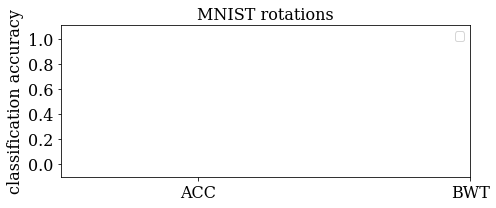

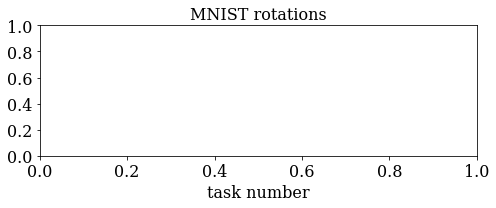

In [30]:
import matplotlib as mpl
import tkinter
mpl.use('TkAgg')
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.family"] = "DejaVu Serif"

from matplotlib import pyplot as plt
from glob import glob
import numpy as np
import torch

models = ['gem']
datasets = ['mnist_rotations']

names_datasets = {'mnist_rotations': 'MNIST rotations'}

names_models = {'gem': 'GEM'}

colors = {'gem': 'C4'}

barplot = {}

for dataset in datasets:
    barplot[dataset] = {}
    for model in models:
        barplot[dataset][model] = {}
        matches = glob(model + '*' + dataset + '*.pt')
        if len(matches):
            data = torch.load(matches[0], map_location=lambda storage, loc: storage)
            acc, bwt, fwt = data[3][:]
            barplot[dataset][model]['acc'] = acc
            barplot[dataset][model]['bwt'] = bwt
            barplot[dataset][model]['fwt'] = fwt

for dataset in datasets:
    x_lab = []
    y_acc = []
    y_bwt = []
    y_fwt = []

    for i, model in enumerate(models):
        if barplot[dataset][model] != {}:
            x_lab.append(model)
            y_acc.append(barplot[dataset][model]['acc'])
            y_bwt.append(barplot[dataset][model]['bwt'])
            y_fwt.append(barplot[dataset][model]['fwt'])

    x_ind = np.arange(len(y_acc))

    plt.figure(figsize=(7, 3))
    all_colors = []
    for xi, yi, li in zip(x_ind, y_acc, x_lab):
        plt.bar(xi, yi, label=names_models[li], color=colors[li])
        all_colors.append(colors[li])
    plt.bar(x_ind + (len(y_acc) + 1) * 1, y_bwt, color=all_colors)
    plt.bar(x_ind + (len(y_acc) + 1) * 2, y_fwt, color=all_colors)
    plt.xticks([0.01, 2, 4], ['ACC', 'BWT', 'FWT'], fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim(-1, len(y_acc) * 3 + 2)
    plt.ylabel('classification accuracy', fontsize=16)
    plt.title(names_datasets[dataset], fontsize=16)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('barplot_%s.pdf' % dataset, bbox_inches='tight')
    plt.show()

evoplot = {}

for dataset in datasets:
    evoplot[dataset] = {}
    for model in models:
        matches = glob(model + '*' + dataset + '*.pt')
        if len(matches):
            data = torch.load(matches[0], map_location=lambda storage, loc: storage)
            evoplot[dataset][model] = data[1][:, 0].numpy()

for dataset in datasets:

    plt.figure(figsize=(7, 3))
    for model in models:
        if model in evoplot[dataset]:
            x = np.arange(len(evoplot[dataset][model]))
            x = (x - x.min()) / (x.max() - x.min()) * 10
            plt.plot(x, evoplot[dataset][model], color=colors[model], lw=3)
            plt.xticks(range(0, 11, 2))

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('task number', fontsize=16)
    plt.title(names_datasets[dataset], fontsize=16)
    plt.tight_layout()
    plt.savefig('evoplot_%s.pdf' % dataset, bbox_inches='tight')
    plt.show()
  
